## Загрузка и обзор содержания датасетов

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

### **games.csv**

*метаданные об играх (например, кто пошел первым, контроль времени)*

In [ ]:
games_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Scrabble Player/games.csv')
print(games_df.shape)
games_df.head()

(72773, 12)


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


* time_control_name - используемый контроль времени ("regular", "rapid", or "blitz")
* initial_time_seconds - ограничение по времени, которое есть у каждого игрока в игре (определяется типом контроля времени)
* increment_seconds - увеличение времени, которое каждый игрок получает каждый раз, когда играет ход
* rating_mode - учитывается ли игра в рейтингах игроков или нет ("RATED", "CASUAL")
* max_overtime_minutes - как далеко игроки могут пройти после первоначального лимита времени до истечения тайм-аута

In [ ]:
games_df.isnull().sum()

game_id                  0
first                    0
time_control_name        0
game_end_reason          0
winner                   0
created_at               0
lexicon                  0
initial_time_seconds     0
increment_seconds        0
rating_mode              0
max_overtime_minutes     0
game_duration_seconds    0
dtype: int64

In [ ]:
print(games_df['created_at'].min(), '/', games_df['created_at'].max())

2022-07-27 08:53:39 / 2022-09-23 17:21:29


In [ ]:
games_df[['time_control_name', 'game_end_reason', 'lexicon', 'rating_mode']].describe()

,time_control_name,game_end_reason,lexicon,rating_mode
count,72773,72773,72773,72773
unique,4,4,4,2
top,regular,STANDARD,CSW21,RATED
freq,60282,67987,44594,54076


### **turns.csv**

*содержит полные данные для каждого хода для каждой игры*

In [ ]:
turns_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Scrabble Player/turns.csv')
print(turns_df.shape)
turns_df.head()

(2005498, 9)


,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


* turn_number - номер хода
* rack - текущая дощечка игрока
* move - плитки, выложенные игроком (также зависят от turn_type)
* points - заработанные или потерянные за ход очки
* score - общий счет игрока на момент хода

In [ ]:
turns_df.isnull().sum()

game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

In [ ]:
turns_df['location'].nunique()

418

In [ ]:
turns_df['turn_type'].value_counts(normalize = True).round(4)

Play             0.9340
End              0.0339
Exchange         0.0244
Pass             0.0040
Timeout          0.0021
Challenge        0.0013
Six-Zero Rule    0.0002
Name: turn_type, dtype: float64

### **test.csv / train.csv**

За исключением трех ботов, ни в train.csv, ни в test.csv нет игроков. Рейтинги игроков даны ДО того, как игра была сыграна. Задача состоит в том, чтобы предсказать, какой рейтинг игрока-человека был в test.csv ДО того, как была сыграна данная игра.

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Scrabble Player/train.csv')
print(train_df.shape)
train_df.head()

(100820, 4)


,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/Scrabble Player/test.csv')
print(test_df.shape)
test_df.head()

(44726, 4)


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


## Разведочный анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
from scipy.stats import spearmanr
import scipy.stats as st

Проведя анализ информации об играх, которая размещена на сайте woogles.io, можно сказать, что точная хронология событий не соблюдена и есть пропущенные игры. Таким образом, не стоит ориентироваться на величину изменения рейтинга от одной игры к следующей, так как этот признак будет некорректным.

Первоночально, это не было очевидным и я планировал использовать данный показатель в совем исследовании.

В таком случае, гипотезой, от которой буду оттакливаться в построении анализа будет предположение, что определенный уровень рейтинга стиль игры.

### **Рейтинг, результат, набранные очки**

In [ ]:
test_ids = test_df['game_id'].unique()
bots_names = ['BetterBot', 'STEEBot', 'HastyBot']

In [ ]:
general_ratings = train_df.append(test_df)
general_ratings = general_ratings.sort_values('game_id')
general_ratings.head()

,game_id,nickname,score,rating
0,1,BetterBot,335,1637.0
1,1,stevy,429,1500.0
1,2,BetterBot,401,2000.0
0,2,Super,488,NaN
3,3,BetterBot,318,2071.0


In [ ]:
only_players_ratings = general_ratings[~general_ratings['nickname'].isin(bots_names)]

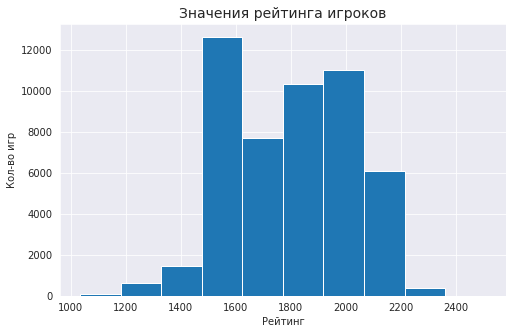

In [ ]:
plt.figure(figsize = (8, 5))
plt.hist(only_players_ratings['rating'])
plt.title('Значения рейтинга игроков', fontsize = 14)
plt.xlabel('Рейтинг')
plt.ylabel('Кол-во игр')
plt.show()

**Первая зависимоть, которую исследуем - взаимосвязь между количеством набранных очков и текущим рейтингом. Предполагаем наличие положительной корелляции.**

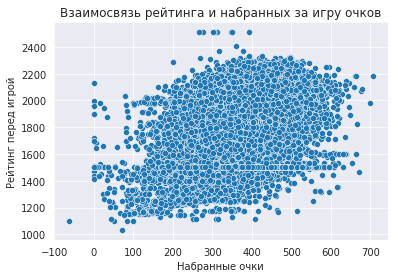

In [ ]:
sns.scatterplot(data = only_players_ratings, x = 'score', y = 'rating')
plt.title('Взаимосвязь рейтинга и набранных за игру очков')
plt.xlabel('Набранные очки')
plt.ylabel('Рейтинг перед игрой')
plt.show()

In [ ]:
# Временный датасет бех тестовых данных, которые содержат пропуски.
data_for_analysis = only_players_ratings[~only_players_ratings['game_id'].isin(test_ids)]

rho, p = spearmanr(data_for_analysis['score'], data_for_analysis['rating'])
print('Полученный к-т корреляции: {}'.format(round(rho, 2)))
print('P-значение меньше 0.05: {}'.format(p < 0.05))

Полученный к-т корреляции: 0.32
P-значение меньше 0.05: True


**Также, можно предположить, что игроки с более высоким рейтингом чаще выигрывают.**

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'winner']], how = 'left', on = 'game_id')

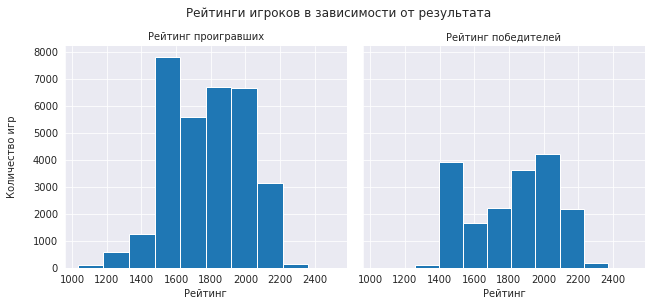

In [ ]:
grid = sns.FacetGrid(only_players_ratings.query('winner>=0'), col = 'winner', height = 4, aspect = 1.1)
grid.map(plt.hist, 'rating')
grid.fig.suptitle('Рейтинги игроков в зависимости от результата', y = 1.05, fontsize = 12)
grid.set_axis_labels('Рейтинг', 'Количество игр\n')
for attr, ax in grid.axes_dict.items():
  if attr == 0:
    ax.set_title('Рейтинг проигравших', fontsize = 10)
  else:
    ax.set_title('Рейтинг победителей', fontsize = 10)
plt.show()

In [ ]:
data_for_analysis = only_players_ratings[~only_players_ratings['game_id'].isin(test_ids)]

winners = data_for_analysis.query('winner==1')['rating'].values
losers = data_for_analysis.query('winner==0')['rating'].values

In [ ]:
st.t.interval(alpha=0.95, df = len(winners)-1, loc = np.mean(winners), 
              scale = st.sem(winners))

(1819.0585268318077, 1825.80411899694)

In [ ]:
st.t.interval(alpha=0.95, df = len(losers)-1, loc = np.mean(losers), 
              scale = st.sem(losers))

(1769.6741888352856, 1774.6301725548685)

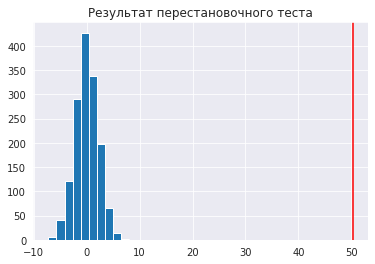

In [ ]:
array_united = np.hstack([winners, losers])
difference_of_averages = (np.mean(winners) - np.mean(losers))
differences = []

for iteration in range(1500):
  array_permutation = np.random.permutation(array_united)
  group_1 = array_permutation[:winners.shape[0]]
  group_2 = array_permutation[winners.shape[0]:]
  differences.append((np.mean(group_1) - np.mean(group_2)))

plt.title('Результат перестановочного теста')
plt.hist(differences)
plt.axvline(difference_of_averages, color = 'red')
plt.show()

**Далее, проверим, коррелирует ли разница в рейтинге с разницой в набранных очках**

In [ ]:
only_players_ratings = only_players_ratings.merge(general_ratings[general_ratings['nickname'].isin(bots_names)]
                                                  [['game_id', 'score', 'rating']], how = 'left', on = 'game_id')
only_players_ratings.head()

,game_id,nickname,score_x,rating_x,winner,score_y,rating_y
0,1,stevy,429,1500.0,1,335,1637.0
1,2,Super,488,NaN,1,401,2000.0
2,3,davidavid,440,1811.0,1,318,2071.0
3,4,Inandoutworker,119,1473.0,0,478,1936.0
4,5,stevy,325,1500.0,0,427,1844.0


In [ ]:
rename_columns = {'score_x': 'player_score', 'score_y': 'bot_score', 
                  'rating_x': 'player_rating', 'rating_y': 'bot_rating'}
only_players_ratings.rename(columns = rename_columns, inplace = True)

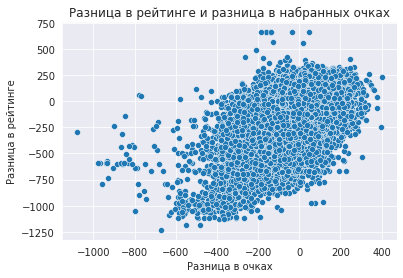

In [ ]:
data_for_analysis = only_players_ratings[~only_players_ratings['game_id'].isin(test_ids)]

scores_diff = (data_for_analysis['player_score'] - data_for_analysis['bot_score'])

rating_diff = (data_for_analysis['player_rating'] - data_for_analysis['bot_rating'])

sns.scatterplot(x = scores_diff, y = rating_diff)
plt.title('Разница в рейтинге и разница в набранных очках')
plt.xlabel('Разница в очках')
plt.ylabel('Разница в рейтинге')
plt.show()

In [ ]:
rho, p = spearmanr(scores_diff, rating_diff)
print('Полученный к-т корреляции: {}'.format(round(rho, 2)))
print('P-значение меньше 0.05: {}'.format(p < 0.05))

Полученный к-т корреляции: 0.34
P-значение меньше 0.05: True


### **Рейтинг и общие данные об игре** 

*В качестве дальнейшего анализа, будем использовать категориальные данные из датасета games_df для выявления дополнительных зависимостей*

#### **Категориальные признаки**

In [ ]:
games_df.head()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


In [ ]:
categoricals = ['time_control_name', 'game_end_reason', 'lexicon', 'rating_mode']

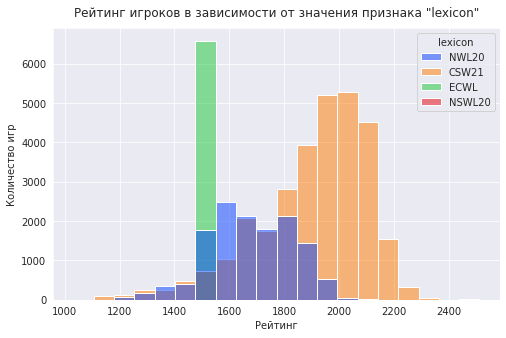

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'lexicon']], how = 'left', on = 'game_id')

plt.figure(figsize = (8, 5))
sns.histplot(data = only_players_ratings, x = 'player_rating', hue = 'lexicon', bins = 20, palette = 'bright')
plt.title('Рейтинг игроков в зависимости от значения признака "lexicon"', y = 1.02)
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show()

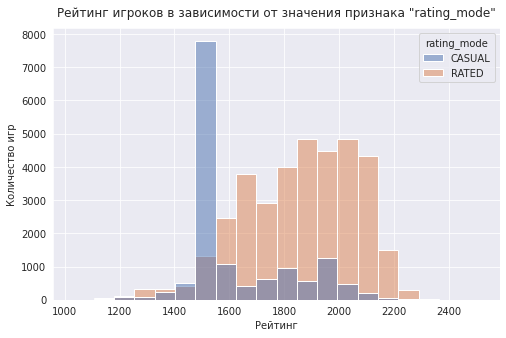

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'rating_mode']], how = 'left', on = 'game_id')

plt.figure(figsize = (8, 5))
sns.histplot(data = only_players_ratings, x = 'player_rating', hue = 'rating_mode', bins = 20, palette = 'deep')
plt.title('Рейтинг игроков в зависимости от значения признака "rating_mode"', y = 1.02)
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show()

In [ ]:
only_players_ratings['rating_mode'] = only_players_ratings['rating_mode'].map({'RATED': 1, 'CASUAL': 0})

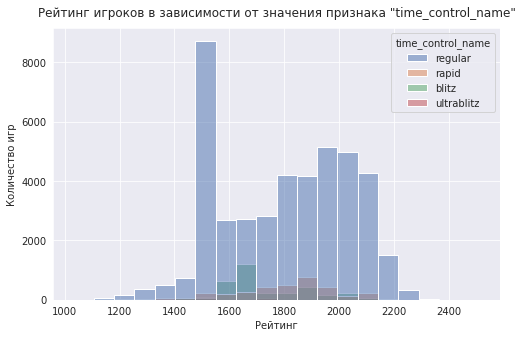

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'time_control_name']], how = 'left', on = 'game_id')

plt.figure(figsize = (8, 5))
sns.histplot(data = only_players_ratings, x = 'player_rating', hue = 'time_control_name', bins = 20, palette = 'deep')
plt.title('Рейтинг игроков в зависимости от значения признака "time_control_name"', y = 1.02)
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show()

In [ ]:
only_players_ratings['regular_time'] = 0
only_players_ratings.loc[only_players_ratings['time_control_name'] == 'regular', 'regular_time'] = 1
only_players_ratings = only_players_ratings.drop('time_control_name', axis = 1)

#### **Числовые признаки**

In [ ]:
numericals = ['initial_time_seconds', 'increment_seconds', 'max_overtime_minutes', 'game_duration_seconds']

In [ ]:
for col in numericals:
  print('{} - {} уник. значений'.format(col, games_df[col].nunique()))

initial_time_seconds - 34 уник. значений
increment_seconds - 11 уник. значений
max_overtime_minutes - 8 уник. значений
game_duration_seconds - 72770 уник. значений


In [ ]:
games_df['increment_seconds'].value_counts(normalize = True)

0     0.969480
1     0.011900
5     0.007819
10    0.007585
60    0.001470
3     0.000824
7     0.000632
15    0.000192
59    0.000055
2     0.000027
30    0.000014
Name: increment_seconds, dtype: float64

In [ ]:
games_df['max_overtime_minutes'].value_counts(normalize = True)

1     0.762439
10    0.121762
0     0.063032
2     0.026617
5     0.015102
3     0.009344
4     0.001676
6     0.000027
Name: max_overtime_minutes, dtype: float64

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'max_overtime_minutes']], how = 'left', on = 'game_id')
only_players_ratings['max_minutes_isOne'] = 0
only_players_ratings.loc[only_players_ratings['max_overtime_minutes'] == 1, 'max_minutes_isOne'] = 1
only_players_ratings = only_players_ratings.drop('max_overtime_minutes', axis = 1)

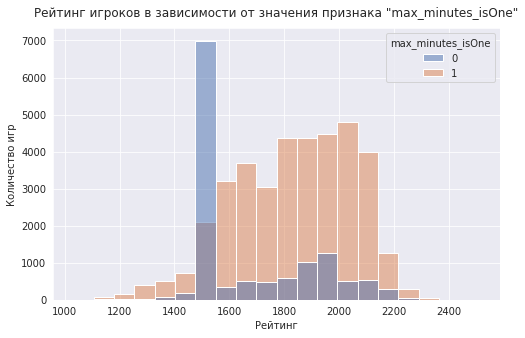

In [ ]:
plt.figure(figsize = (8, 5))
sns.histplot(data = only_players_ratings, x = 'player_rating', hue = 'max_minutes_isOne', bins = 20, palette = 'deep')
plt.title('Рейтинг игроков в зависимости от значения признака "max_minutes_isOne"', y = 1.02)
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show()

In [ ]:
only_players_ratings.groupby('max_minutes_isOne')['player_rating'].agg(['mean', 'median', 'max'])

,mean,median,max
max_minutes_isOne,,,
0,1667.735760,1500.0,2299.0
1,1832.419865,1853.0,2510.0


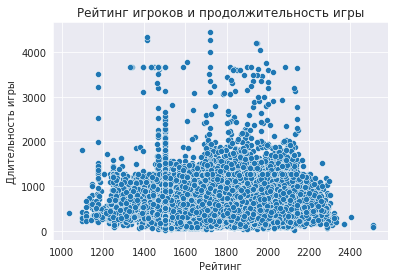

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'game_duration_seconds']], how = 'left', on = 'game_id')

sns.scatterplot(data = only_players_ratings, x = 'player_rating', y = 'game_duration_seconds')
plt.title('Рейтинг игроков и продолжительность игры')
plt.xlabel('Рейтинг')
plt.ylabel('Длительность игры')
plt.show()

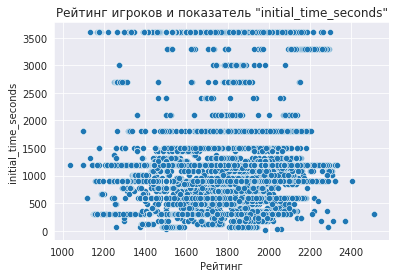

In [ ]:
only_players_ratings = only_players_ratings.merge(games_df[['game_id', 'initial_time_seconds']], how = 'left', on = 'game_id')

sns.scatterplot(data = only_players_ratings, x = 'player_rating', y = 'initial_time_seconds')
plt.title('Рейтинг игроков и показатель "initial_time_seconds"')
plt.xlabel('Рейтинг')
plt.ylabel('initial_time_seconds')
plt.show()

In [ ]:
only_players_ratings = only_players_ratings.drop(['game_duration_seconds', 'initial_time_seconds'], axis = 1)
only_players_ratings.head()

,game_id,nickname,player_score,player_rating,winner,bot_score,bot_rating,lexicon,rating_mode,regular_time,max_minutes_isOne
0,1,stevy,429,1500.0,1,335,1637.0,NWL20,0,1,1
1,2,Super,488,NaN,1,401,2000.0,CSW21,1,1,1
2,3,davidavid,440,1811.0,1,318,2071.0,CSW21,1,1,0
3,4,Inandoutworker,119,1473.0,0,478,1936.0,CSW21,0,1,1
4,5,stevy,325,1500.0,0,427,1844.0,NWL20,0,1,1


In [ ]:
only_bots = general_ratings[general_ratings['nickname'].isin(bots_names)]
only_bots['bot_level'] = only_bots['nickname'].map({'BetterBot': 0, 'STEEBot': 1, 'HastyBot': 2})
only_players_ratings = only_players_ratings.merge(only_bots[['game_id', 'bot_level']], how = 'left', on = 'game_id')
only_players_ratings.head()

,game_id,nickname,player_score,player_rating,winner,bot_score,bot_rating,lexicon,rating_mode,regular_time,max_minutes_isOne,bot_level
0,1,stevy,429,1500.0,1,335,1637.0,NWL20,0,1,1,0
1,2,Super,488,NaN,1,401,2000.0,CSW21,1,1,1,0
2,3,davidavid,440,1811.0,1,318,2071.0,CSW21,1,1,0,0
3,4,Inandoutworker,119,1473.0,0,478,1936.0,CSW21,0,1,1,0
4,5,stevy,325,1500.0,0,427,1844.0,NWL20,0,1,1,1


### **Статистика ходов игрока**


In [ ]:
turns_df.head(3)

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play


In [ ]:
players_turns = turns_df[~turns_df['nickname'].isin(bots_names)]

In [ ]:
players_turns.describe(include = np.object).iloc[1:, 1:]

,rack,location,move,turn_type
unique,424848,418,193697,6
top,I,15A,--,Play
freq,977,13427,14302,928130


In [ ]:
players_turns['turn_type'].value_counts(normalize = True)

Play             0.926819
Exchange         0.034766
End              0.028555
Pass             0.005486
Timeout          0.004136
Six-Zero Rule    0.000238
Name: turn_type, dtype: float64

In [ ]:
players_turns.loc[players_turns['turn_type'] != 'Play', 'move'] = 0
players_turns['move'] = players_turns['move'].fillna(0)

In [ ]:
alphabets = []
for i in range(65,91):
    alphabets.append(chr(i))

In [ ]:
def only_letters(player_turn):
  letters = []
  if player_turn == 0:
    return 0
  else:
    for letter in player_turn:
      if letter in alphabets:
        letters.append(letter)
    return len(letters)

In [ ]:
players_turns['word_length'] = players_turns['move'].apply(lambda x: only_letters(x))

In [ ]:
players_turns['word_length'].value_counts(normalize = True).sort_values()

1    0.048691
7    0.060386
6    0.070149
0    0.073781
5    0.082335
4    0.179483
2    0.200922
3    0.284252
Name: word_length, dtype: float64

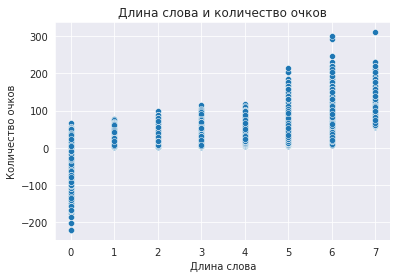

In [ ]:
sns.scatterplot(data = players_turns, x = 'word_length', y = 'points')
plt.title('Длина слова и количество очков')
plt.xlabel('Длина слова')
plt.ylabel('Количество очков')
plt.show()

In [ ]:
turns_statistics = players_turns.groupby('game_id', as_index = False)['word_length'].agg(['mean', 'sum'])
turns_statistics.rename(columns = {'mean': 'AVG_word_length', 'sum': 'sum_of_letters'}, inplace = True)

temporary_data = players_turns.groupby('game_id', as_index = False).agg({'turn_number': 'count', 'points': 'mean'})
temporary_data.rename(columns = {'turn_number': 'number_of_turns', 'points': 'AVG_of_points'}, inplace = True)

turns_statistics = turns_statistics.merge(temporary_data, how = 'left', on = 'game_id')
turns_statistics.head()

,game_id,AVG_word_length,sum_of_letters,number_of_turns,AVG_of_points
0,1,3.214286,45,14,30.642857
1,2,3.357143,47,14,34.857143
2,3,3.428571,48,14,31.428571
3,4,1.357143,19,14,8.500000
4,5,2.500000,40,16,20.312500


In [ ]:
only_players_ratings = only_players_ratings.merge(turns_statistics, how = 'left', on = 'game_id')
only_players_ratings.head()

,game_id,nickname,player_score,player_rating,winner,bot_score,bot_rating,lexicon,rating_mode,regular_time,max_minutes_isOne,bot_level,AVG_word_length,sum_of_letters,number_of_turns,AVG_of_points
0,1,stevy,429,1500.0,1,335,1637.0,NWL20,0,1,1,0,3.214286,45,14,30.642857
1,2,Super,488,NaN,1,401,2000.0,CSW21,1,1,1,0,3.357143,47,14,34.857143
2,3,davidavid,440,1811.0,1,318,2071.0,CSW21,1,1,0,0,3.428571,48,14,31.428571
3,4,Inandoutworker,119,1473.0,0,478,1936.0,CSW21,0,1,1,0,1.357143,19,14,8.500000
4,5,stevy,325,1500.0,0,427,1844.0,NWL20,0,1,1,1,2.500000,40,16,20.312500


In [ ]:
train_data = only_players_ratings[~only_players_ratings['game_id'].isin(test_ids)]\
            .drop(['game_id', 'nickname', 'player_rating'], axis = 1)
test_data = only_players_ratings[only_players_ratings['game_id'].isin(test_ids)]\
            .drop(['game_id', 'nickname', 'player_rating'], axis = 1)

In [ ]:
features = pd.get_dummies(train_data)
features = features.drop(['lexicon_NSWL20'], axis = 1)

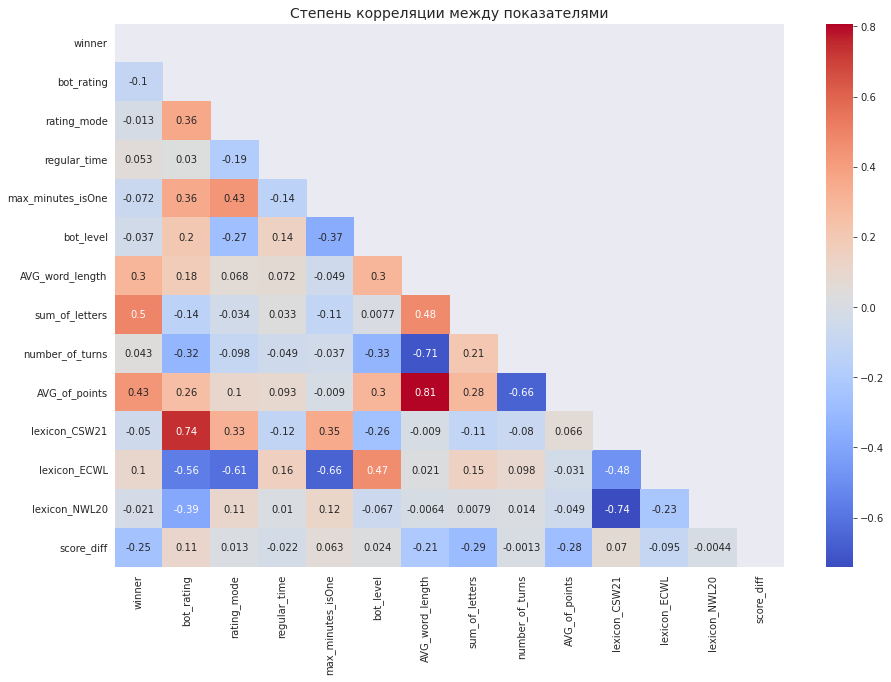

In [ ]:
plt.figure(figsize = (15, 10))
matrix = np.triu(features.corr())
sns.heatmap(features.corr(method='spearman'), annot = True, mask = matrix, cmap = 'coolwarm')
plt.title('Степень корреляции между показателями', fontsize = 14)
plt.show()

In [ ]:
features = features.drop('AVG_of_points', axis = 1)

In [ ]:
test_data = pd.get_dummies(test_data)
if 'lexicon_NSWL20' in test_data.columns:
  test_data = test_data.drop(['lexicon_NSWL20', 'AVG_of_points'], axis = 1)
else:
  test_data = test_data.drop(['AVG_of_points'], axis = 1)

### **Построение модели**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.metrics import r2_score
rom sklearn.metrics import mean_absolute_error

In [ ]:
targets = only_players_ratings[~only_players_ratings['game_id'].isin(test_ids)]['player_rating']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, 
                                                    random_state = 17)

In [ ]:
pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(), Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.01, 0.05, 0.1, 0.5, 1, 10, 50,
                                          100]})

In [ ]:
print('RIDGE')
print('*' * 35)
print(f'Правильность на обучающем наборе: {round(grid.score(x_train, y_train), 4)}')
print()
print(f'Правильность на тестовом наборе: {round(grid.score(x_test, y_test), 4)}')

RIDGE
***********************************
Правильность на обучающем наборе: 0.6815

Правильность на тестовом наборе: 0.671


In [ ]:
rfr = RandomForestRegressor(n_estimators = 350, max_depth = 12, random_state = 17, n_jobs = -1)
rfr_model = rfr.fit(x_train, y_train)
rfr_predict = rfr_model.predict(x_test)

print('RandomForestRegressor')
print('*' * 35)
print(f'Правильность на обучающем наборе: {round(rfr_model.score(x_train, y_train), 4)}')
print()
print(f'Правильность на тестовом наборе: {round(rfr_model.score(x_test, y_test), 4)}')

RandomForestRegressor
***********************************
Правильность на обучающем наборе: 0.773

Правильность на тестовом наборе: 0.685


In [ ]:
gbr = GradientBoostingRegressor(n_estimators = 300, max_depth = 7,  
                                learning_rate = 0.05, random_state = 17)
gbr_model = gbr.fit(x_train, y_train)
gbr_predict = gbr_model.predict(x_test)

print('GradientBoostingRegressor')
print('*' * 35)
print(f'Правильность на обучающем наборе: {round(gbr_model.score(x_train, y_train), 4)}')
print()
print(f'Правильность на тестовом наборе: {round(gbr_model.score(x_test, y_test), 4)}')

GradientBoostingRegressor
***********************************
Правильность на обучающем наборе: 0.7776

Правильность на тестовом наборе: 0.698
